## Import library

In [1]:
%run functions

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Load data

In [7]:
loader = DataLoader()
loader.GetData('final')
d = loader.GetShuffled(1000)
d.head()

,用户ID,学号,姓名,班级,院系,任课教师,Class,Prompt,score,text
3249,1003247070,21120892,谭浩然,2021-22冬季通用英语C2周健华1024期末,机电工程与自动化学院,1002658409(周健华),C,19121440,9.0,"As we know,reading has a lot of advantages f..."
1221,1003246436,21120258,陈辰,2021-22冬季通用英语B2朱虹1028期末,社会学院,1002658416(朱虹),B,19121440,11.9,"Nowadays, with the growing development o..."
1600,1003247064,21120886,杨浩辰,2021-22冬季通用英语B2薛清1013期末,通信与信息工程学院,1002658414(薛清),B,19121413,10.8,It has been more than 7 months when coming int...
2845,1003250658,21124485,聂子晨,2021-22冬季通用英语C2张季红1014期末,音乐学院,1002658404(张季红),C,19121436,9.4,How to learn a foreign language，different ...
3422,1003249020,21122847,陶钧,2021-22冬季通用英语C2张季红1002期末,计算机工程与科学学院,1002658404(张季红),C,1000561535,9.6,"Today,we are amaziing at the frequency of ..."


In [8]:
d = d.loc[d['score'] > 0,:]

## Regression
### Split for train and test index

In [9]:
ind = list(d.index)
ind = shuffle(ind)
trainIn,testIn = ind[:2838],ind[2838:]

### CLS/Mean pooling embeddings

In [10]:
x1 = torch.load('features/final-meanp.pt')

In [11]:
x1 = [np.array(i).reshape(1024) for i in x1]

#### Create train and test data

In [12]:
TrainX,TestX = [x1[i] for i in trainIn],[x1[i] for i in testIn]
TrainY,TestY = d['score'][trainIn],d['score'][testIn]

#### Fit the model and get prediction results

In [13]:
model = xgb.XGBRegressor(learning_rate=0.042)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
PredTrainY = model.predict(TrainX)

#### Performance evaluation

In [14]:
mean_squared_error(TestY,PredY,squared=False),explained_variance_score(TestY,PredY),r2_score(TestY,PredY)

(0.6114396220521967, 0.8215323131428809, 0.8148404853877358)

In [15]:
mean_squared_error(TrainY,PredTrainY,squared=False),explained_variance_score(TrainY,PredTrainY),r2_score(TrainY,PredTrainY)

(0.25798804664603636, 0.9734588542744004, 0.962639366297835)

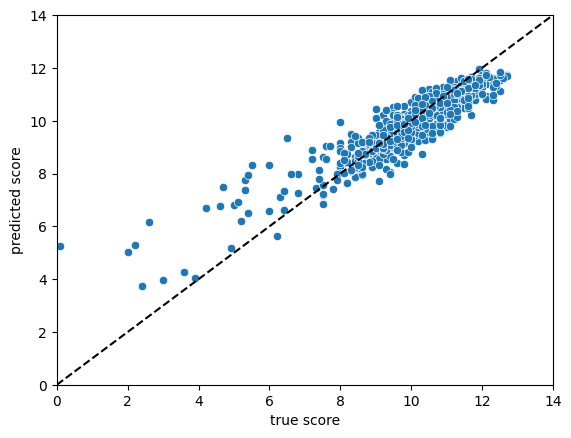

In [16]:
g = sns.scatterplot(x=TestY,y=PredY)
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((0,14))
g.set_xlim((0,14))
g = sns.lineplot(x=[0,14],y=[0,14],color='black')
g.lines[0].set_linestyle("--")

## Fine-grained features

In [17]:
x2 = []
with open('features/final-winter-fine.csv') as f:
    raw = f.readlines()[1:]

In [18]:
for i in range(len(raw)):
    l = raw[i]
    l = l.rstrip('\n').split(',')[2:]
    l = [float(i) for i in l]
    if i in list(d.index):
        x2.append(np.array(l,dtype=float).reshape(143))
    else:
        x2.append([0])

#### Create train and test data

In [19]:
TrainX,TestX = [x2[i] for i in trainIn],[x2[i] for i in testIn]
TrainY,TestY = d['score'][trainIn],d['score'][testIn]

#### Fit the model and get predictions

In [20]:
model = xgb.XGBRegressor(learning_rate=0.042)
#model = linear_model.LinearRegression()
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
PredTrainY = model.predict(TrainX)

#### Performance evaluation

In [21]:
mean_squared_error(TestY,PredY,squared=False),explained_variance_score(TestY,PredY),r2_score(TestY,PredY)

(0.7728158904512359, 0.7120313481974121, 0.704204907710628)

In [22]:
mean_squared_error(TrainY,PredTrainY,squared=False),explained_variance_score(TrainY,PredTrainY),r2_score(TrainY,PredTrainY)

(0.47889391575135903, 0.881826137842308, 0.8712658693965192)

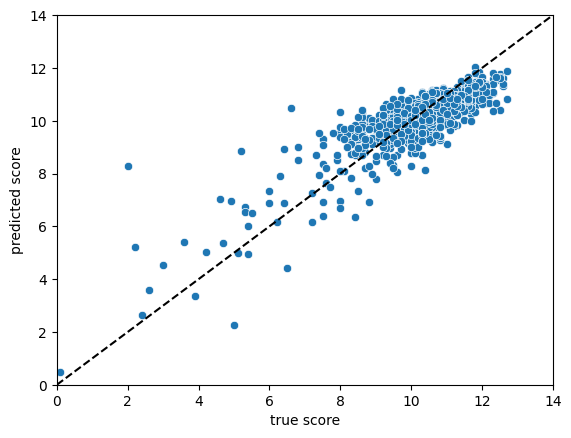

In [23]:
g = sns.scatterplot(x=TestY,y=PredY)
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((0,14))
g.set_xlim((0,14))
g = sns.lineplot(x=[0,14],y=[0,14],color='black')
g.lines[0].set_linestyle("--")

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

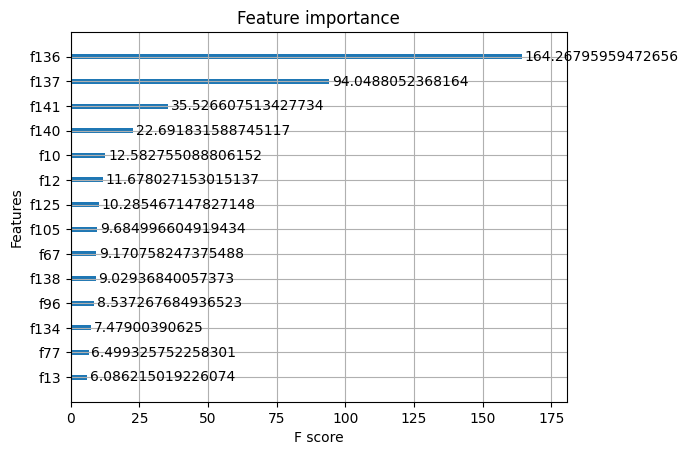

In [24]:
xgb.plot_importance(model,max_num_features=14,importance_type='gain')

#### 14 best fine-grained features

In [25]:
best_features=[136,137,141,140,10,12,125,105,67,138,96,77,13,134]
x_2best = []
for sample in x2:
    if len(sample) >1:
        x_2best.append([sample[i] for i in best_features])
    else:
        x_2best.append([])

In [26]:
TrainX,TestX = [x_2best[i] for i in trainIn],[x_2best[i] for i in testIn]
TrainY,TestY = d['score'][trainIn],d['score'][testIn]

In [27]:
model = xgb.XGBRegressor(learning_rate=0.042)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
PredTrainY = model.predict(TrainX)

In [28]:
mean_squared_error(TestY,PredY,squared=False),explained_variance_score(TestY,PredY),r2_score(TestY,PredY)

(0.8123150544219113, 0.6794837006169657, 0.6731956103791122)

In [29]:
mean_squared_error(TrainY,PredTrainY,squared=False),explained_variance_score(TrainY,PredTrainY),r2_score(TrainY,PredTrainY)

(0.5987597472070493, 0.8091779669123615, 0.7987572431318275)

### Mean pooling + fine-grained

In [30]:
x3 = []
for i in range(3830):
    a = np.concatenate((x1[i],x2[i]))
    x3.append(a)

#### Create train and test data

In [31]:
TrainX,TestX = [x3[i] for i in trainIn],[x3[i] for i in testIn]
TrainY,TestY = d['score'][trainIn],d['score'][testIn]

#### Fit the model and get predictions

In [32]:
model = xgb.XGBRegressor(learning_rate=0.042)
#model = linear_model.LinearRegression()
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
PredTrainY = model.predict(TrainX)

#### Performance evaluation

In [33]:
mean_squared_error(TestY,PredY,squared=False),explained_variance_score(TestY,PredY),r2_score(TestY,PredY)

(0.5012726910176707, 0.8836429259518969, 0.8755522732824551)

In [34]:
mean_squared_error(TrainY,PredTrainY,squared=False),explained_variance_score(TrainY,PredTrainY),r2_score(TrainY,PredTrainY)

(0.2434636167545943, 0.9774691467563958, 0.9667276708114012)

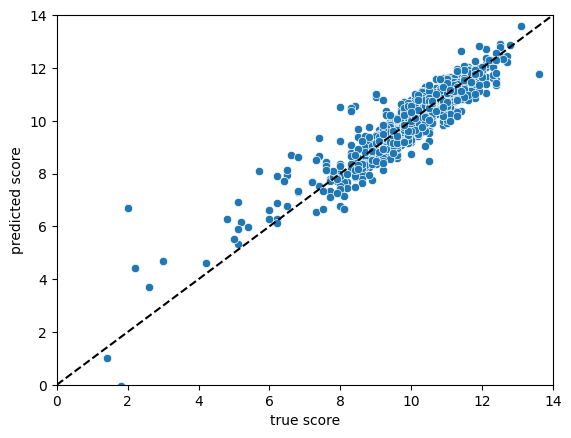

In [90]:
g = sns.scatterplot(x=TestY,y=PredY)
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((0,14))
g.set_xlim((0,14))
g = sns.lineplot(x=[0,14],y=[0,14],color='black')
g.lines[0].set_linestyle("--")

#### Linear regression for fine-grained features

In [43]:
df = pd.read_csv('features/final-winter-fine.csv')
df['score'] = d['score']
df = df.loc[df['score']>0]

In [44]:
features = [df.columns[2:-1][i] for i in best_features]

In [45]:
model = pg.linear_regression(df[features],df['score'])
model['sig'] = [model['pval'][i]<0.05 for i in range(len(model))]

#### selecting significant features

In [46]:
pg.linear_regression(df[model.loc[model['sig']== True]['names'][1:]],df['score'],relimp=True)

C:\Users\GIGA\AppData\Local\Temp\ipykernel_15504\564392207.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pg.linear_regression(df[model.loc[model['sig']== True]['names'][1:]],df['score'],relimp=True)


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,4.628939,0.127459,36.317086,6.458936e-248,0.513106,0.511557,4.379044,4.878834,NaN,NaN
1,token,-0.016349,0.006128,-2.667816,7.667248e-03,0.513106,0.511557,-0.028363,-0.004334,0.063136,12.304672
2,content_word,0.025164,0.006261,4.019303,5.951087e-05,0.513106,0.511557,0.012889,0.037439,0.065479,12.761371
3,unique_noun,0.008846,0.003644,2.427355,1.525591e-02,0.513106,0.511557,0.001701,0.015992,0.047969,9.348691
4,verb_var,0.549096,0.043068,12.749588,1.757192e-36,0.513106,0.511557,0.464658,0.633535,0.069243,13.494891
5,adj_var,0.623220,0.040618,15.343454,1.375452e-51,0.513106,0.511557,0.543585,0.702855,0.076049,14.821230
6,prep,0.008492,0.003826,2.219677,2.649998e-02,0.513106,0.511557,0.000991,0.015993,0.035256,6.871038
7,dep,-0.278585,0.019264,-14.461317,3.580567e-46,0.513106,0.511557,-0.316355,-0.240816,0.032560,6.345724
8,Perf/sent,1.475882,0.260789,5.659305,1.633005e-08,0.513106,0.511557,0.964582,1.987183,0.007511,1.463753
9,function_word,0.022759,0.006265,3.632843,2.840477e-04,0.513106,0.511557,0.010476,0.035042,0.047516,9.260449


### Large-grained features

In [35]:
with open('features/final-winter-l2sca.txt') as f:
    l2 = f.readlines()[1:]
xl = dict()
for l in l2:
    i = int(l.split(',')[0].split('.')[0])
    feat = l.rstrip('\n').split(',')[-14:]
    feat = [float(s) for s in feat]
    xl[i] = feat
x4 = []
for i in range(3830):
    x4.append(xl[i])

In [36]:
TrainX,TestX = [x4[i] for i in trainIn],[x4[i] for i in testIn]
TrainY,TestY = d['score'][trainIn],d['score'][testIn]

In [37]:
model = xgb.XGBRegressor(learning_rate=0.042)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
PredTrainY = model.predict(TrainX)

In [38]:
mean_squared_error(TestY,PredY,squared=False),explained_variance_score(TestY,PredY),r2_score(TestY,PredY)

(1.1884303597525054, 0.30822000105433545, 0.3005021999203865)

In [9]:
mean_squared_error(TrainY,PredTrainY,squared=False),explained_variance_score(TrainY,PredTrainY),r2_score(TrainY,PredTrainY)

(0.958628779634402, 0.5213068173897264, 0.5117979089016893)

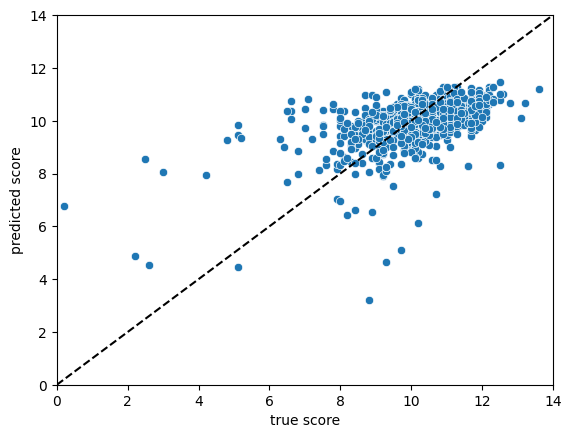

In [10]:
g = sns.scatterplot(x=TestY,y=PredY)
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((0,14))
g.set_xlim((0,14))
g = sns.lineplot(x=[0,14],y=[0,14],color='black')
g.lines[0].set_linestyle("--")

#### Linear regression

In [39]:
df = pd.DataFrame(x4)
df.columns = 'W,S,VP,C,T,DC,CT,CP,CN,MLS,MLT,MLC,C/S,VP/T,C/T,DC/C,DC/T,T/S,CT/T,CP/T,CP/C,CN/T,CN/C'.split(',')[-14:]
df['score'] = d['score']
df = df.loc[(df['score'] > 0)]

In [40]:
model = pg.linear_regression(df['W,S,VP,C,T,DC,CT,CP,CN,MLS,MLT,MLC,C/S,VP/T,C/T,DC/C,DC/T,T/S,CT/T,CP/T,CP/C,CN/T,CN/C'.split(',')[-14:]],df['score'])
model['sig'] = [model['pval'][i]<0.05 for i in range(len(model))]

In [41]:
model.loc[model['sig']== True]

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],sig
0,Intercept,8.274577,0.575602,14.375507,1.164779e-45,0.214211,0.211292,7.146055,9.403100,True
1,MLS,0.120309,0.053424,2.251961,2.438209e-02,0.214211,0.211292,0.015566,0.225053,True
5,VP/T,-0.219291,0.072853,-3.010066,2.629214e-03,0.214211,0.211292,-0.362126,-0.076457,True
7,DC/C,6.152230,0.702163,8.761829,2.853659e-18,0.214211,0.211292,4.775574,7.528886,True
8,DC/T,-1.897805,0.427975,-4.434382,9.496965e-06,0.214211,0.211292,-2.736891,-1.058720,True
9,T/S,-1.122589,0.477200,-2.352451,1.870131e-02,0.214211,0.211292,-2.058184,-0.186994,True
13,CN/T,-0.574971,0.279176,-2.059527,3.951230e-02,0.214211,0.211292,-1.122322,-0.027620,True
14,CN/C,1.665648,0.431214,3.862691,1.140290e-04,0.214211,0.211292,0.820212,2.511084,True


#### Selecting significant features

In [42]:
pg.linear_regression(df[model.loc[model['sig']== True]['names'][1:]],df['score'],relimp=True)

C:\Users\GIGA\AppData\Local\Temp\ipykernel_15504\564392207.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pg.linear_regression(df[model.loc[model['sig']== True]['names'][1:]],df['score'],relimp=True)


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,8.902985,0.239228,37.215514,1.564826e-258,0.208321,0.206853,8.433957,9.372013,NaN,NaN
1,MLS,0.139126,0.010989,12.660661,5.215548e-36,0.208321,0.206853,0.117582,0.160671,0.040493,19.437823
2,VP/T,-0.252789,0.069040,-3.661502,2.541750e-04,0.208321,0.206853,-0.388147,-0.117430,0.010867,5.216478
3,DC/C,6.308462,0.532856,11.838965,8.894884e-32,0.208321,0.206853,5.263749,7.353175,0.032637,15.666770
4,DC/T,-1.803787,0.303210,-5.948970,2.943675e-09,0.208321,0.206853,-2.398258,-1.209316,0.016294,7.821661
5,T/S,-2.161447,0.202647,-10.666057,3.449412e-26,0.208321,0.206853,-2.558756,-1.764138,0.013401,6.432924
6,CN/T,-0.265825,0.149056,-1.783392,7.460278e-02,0.208321,0.206853,-0.558062,0.026413,0.045197,21.696034
7,CN/C,1.146148,0.212054,5.404982,6.882416e-08,0.208321,0.206853,0.730397,1.561900,0.049431,23.728310
